In [1]:
!date

Tue Jul 27 21:33:04 PDT 2021


# Class DE isoform only

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/home/nmarkari/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [4]:
subclass_cmap = pd.read_csv('../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [5]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [6]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [7]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [8]:
print(isoform.shape)
print(gene.shape)

(18175, 81527)
(18175, 26154)


In [9]:
mask = np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic")

c_gene = gene[mask]
c_isoform = isoform[mask]

In [10]:
%%time
mat           = c_gene.layers["log1p"].todense()
components    = c_gene.obs.cell_id.values
features      = c_gene.var.gene_name.values
assignments   = c_gene.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min

27-Jul-21 21:33:34 - 1 of 2 assignments: GABAergic
27-Jul-21 21:33:38 - 2 of 2 assignments: Glutamatergic


CPU times: user 6.68 s, sys: 6.76 s, total: 13.4 s
Wall time: 13.4 s


In [11]:
%%time
mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
components  = c_isoform.obs.cell_id.values
features    = c_isoform.var.transcript_name.values
assignments = c_isoform.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min

27-Jul-21 21:33:56 - 1 of 2 assignments: GABAergic
27-Jul-21 21:34:10 - 2 of 2 assignments: Glutamatergic


CPU times: user 13.7 s, sys: 23.1 s, total: 36.8 s
Wall time: 36.8 s


# Only care about differential isoforms

In [12]:
alpha = 0.01
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")

,index,name,p_raw,p_corr,es
33630,GABAergic,Aldoa-203_ENSMUST00000106348.8,0,2.22507e-308,-2.92672
69854,GABAergic,Chn1os1-201_ENSMUST00000123613.2,0,2.22507e-308,-2.19272
24570,GABAergic,Olfm1-203_ENSMUST00000102879.4,0,2.22507e-308,-2.10222
59285,GABAergic,Chn1-202_ENSMUST00000102677.11,0,2.22507e-308,-1.95147
140188,Glutamatergic,Nap1l5-201_ENSMUST00000059539.5,0,2.22507e-308,-1.92279
...,...,...,...,...,...
107158,Glutamatergic,Itpka-201_ENSMUST00000028758.8,0,2.22507e-308,4.7974
65320,GABAergic,Gad1-201_ENSMUST00000094934.11,0,2.22507e-308,5.12285
128436,Glutamatergic,Nrn1-201_ENSMUST00000037623.15,0,2.22507e-308,5.13671
65317,GABAergic,Gad1-206_ENSMUST00000140478.2,0,2.22507e-308,5.25023


In [13]:
#specific_isoform = "Gad1-206_ENSMUST00000140478"
specific_isoform = "Aldoa-203_ENSMUST00000106348.8"
gene.var[gene.var.gene_name.str.contains(f"{specific_isoform.split('-')[0]}")]

,transcript_id,gene_id,gene_name,transcript_name,length,txn_list,num_isoforms,gene_counts,dispersion,pass_disp_filter,highly_variable,means,dispersions,dispersions_norm
Aldoa_ENSMUSG00000030695.17,ENSMUST00000205890.2,ENSMUSG00000030695.17,Aldoa_ENSMUSG00000030695.17,Aldoa-212_ENSMUST00000205890.2,762,"['ENSMUST00000205890.2', 'ENSMUST00000147748.2...",10,28160.462891,0.196080,True,False,8.192519,5.812237,-0.694511
Aldoart2_ENSMUSG00000063129.2,ENSMUST00000080123.2,ENSMUSG00000063129.2,Aldoart2_ENSMUSG00000063129.2,Aldoart2-201_ENSMUST00000080123.2,1658,['ENSMUST00000080123.2'],1,2.233989,0.008708,True,False,0.249083,2.975697,-0.130702
Aldoa-ps4_ENSMUSG00000111336.2,ENSMUST00000216332.2,ENSMUSG00000111336.2,Aldoa-ps4_ENSMUSG00000111336.2,Aldoa-ps4-201_ENSMUST00000216332.2,753,['ENSMUST00000216332.2'],1,3.780442,0.001355,True,False,0.391841,1.181111,-1.874892
Aldoa_ENSMUSG00000114515.3,ENSMUST00000207534.3,ENSMUSG00000114515.3,Aldoa_ENSMUSG00000114515.3,Aldoa-214_ENSMUST00000207534.3,741,['ENSMUST00000207534.3'],1,5.484130,0.014900,True,False,0.545010,3.738455,0.610637


In [14]:
specific_gene = "Aldoa_ENSMUSG00000030695.17"

In [15]:
specific_cluster = "GABAergic"

In [16]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


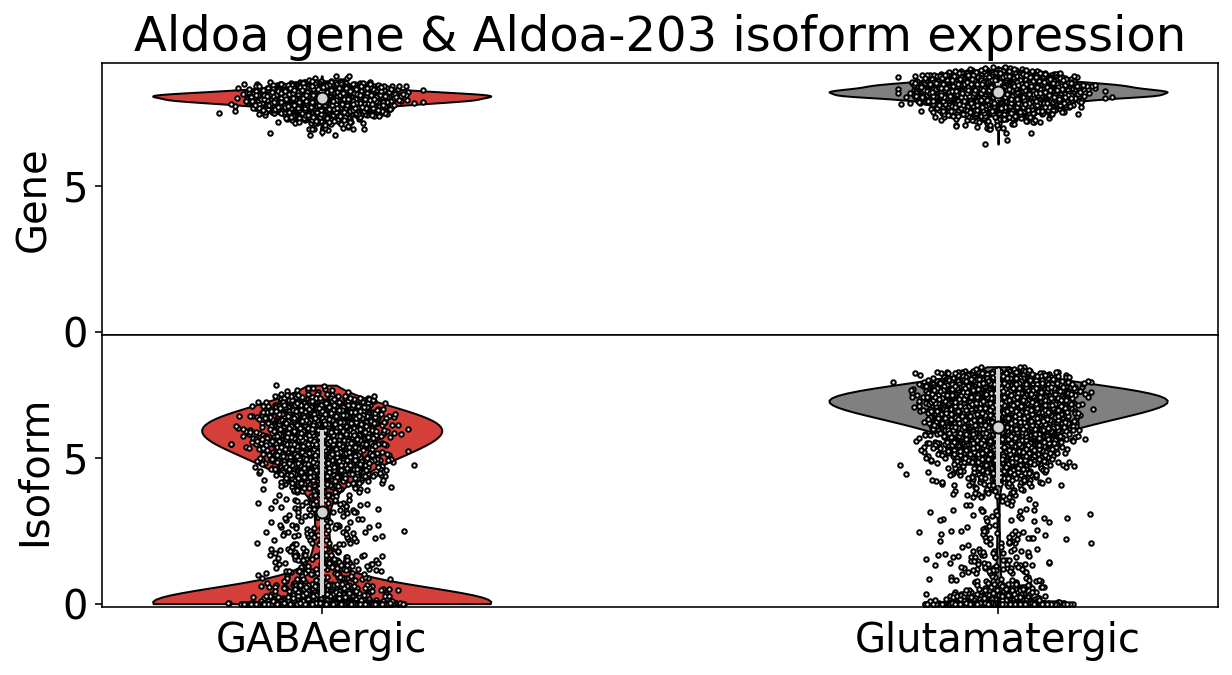

In [17]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.class_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx, xticks=lidx, xticklabels=labels)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.class_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)

ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene",
    "ylim": (-0.1)
})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform",
    "ylim": (ymin, ymax),
})

plt.savefig("../../figures/class_DE_isoform_only_violin_ACA_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

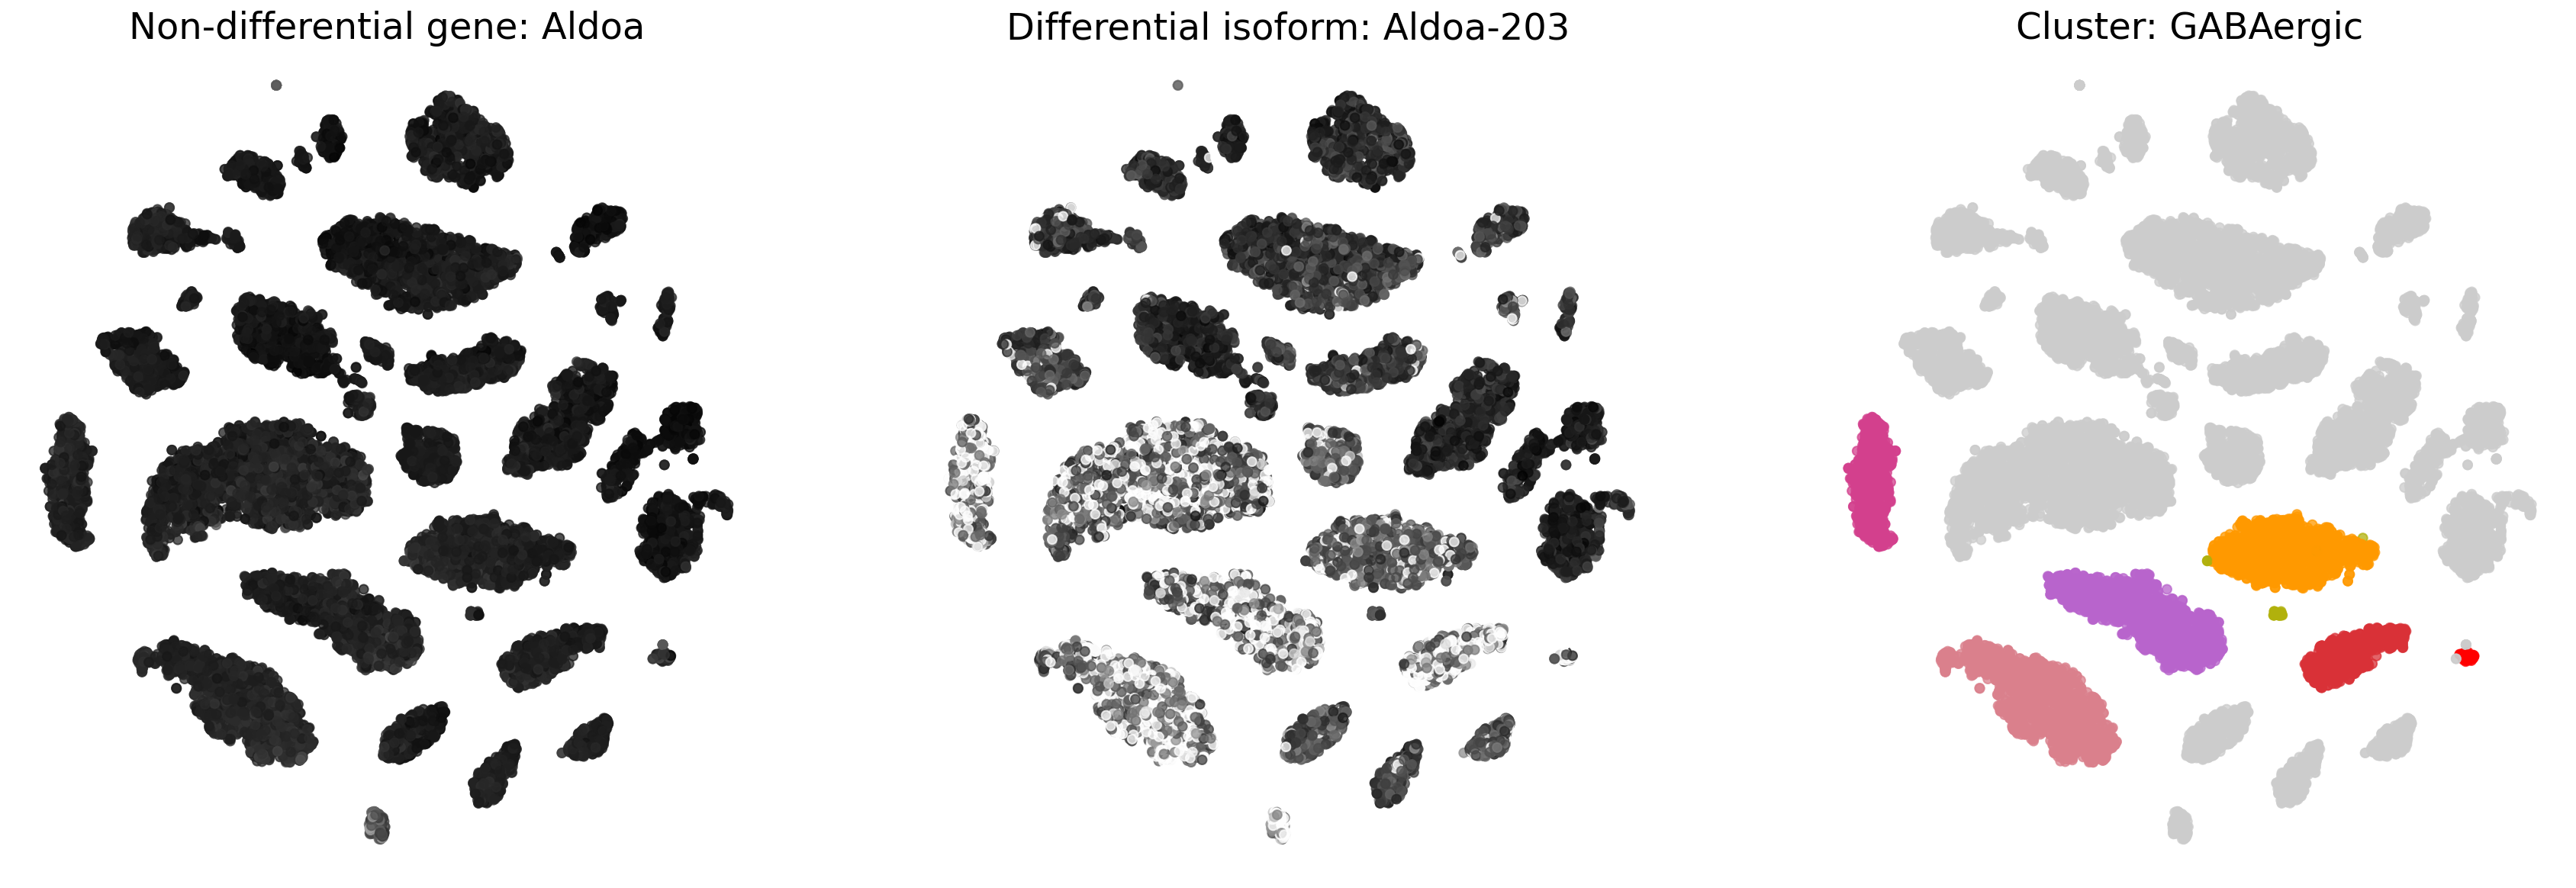

In [18]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(gene.obs["class_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster))
plt.savefig("../../figures/class_DE_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [19]:
identified_isoforms = markers_isoform["name"].explode().astype(str)
identified_isoforms

30          Cox5a-202_ENSMUST00000213678.2
32          Cox5a-201_ENSMUST00000000090.8
183         Comt-202_ENSMUST00000115609.10
198       Dazap2-201_ENSMUST00000000356.10
230        Ndufa9-201_ENSMUST00000088194.7
                        ...               
162125      TUSC3-201_ENSMUST00000239508.1
162248      Rn18s-201_ENSMUST00000240377.1
162418               _ENSMUST00020182542.1
162523               _ENSMUST00020182009.1
162762               _ENSMUST00020183322.1
Name: name, Length: 3801, dtype: object

In [20]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0])

In [21]:
#identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [22]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

3801 isoforms from 1788 genes identified.


In [23]:
markers_isoform.to_csv("../../tables/unordered/class_DE_isoform_only.csv")

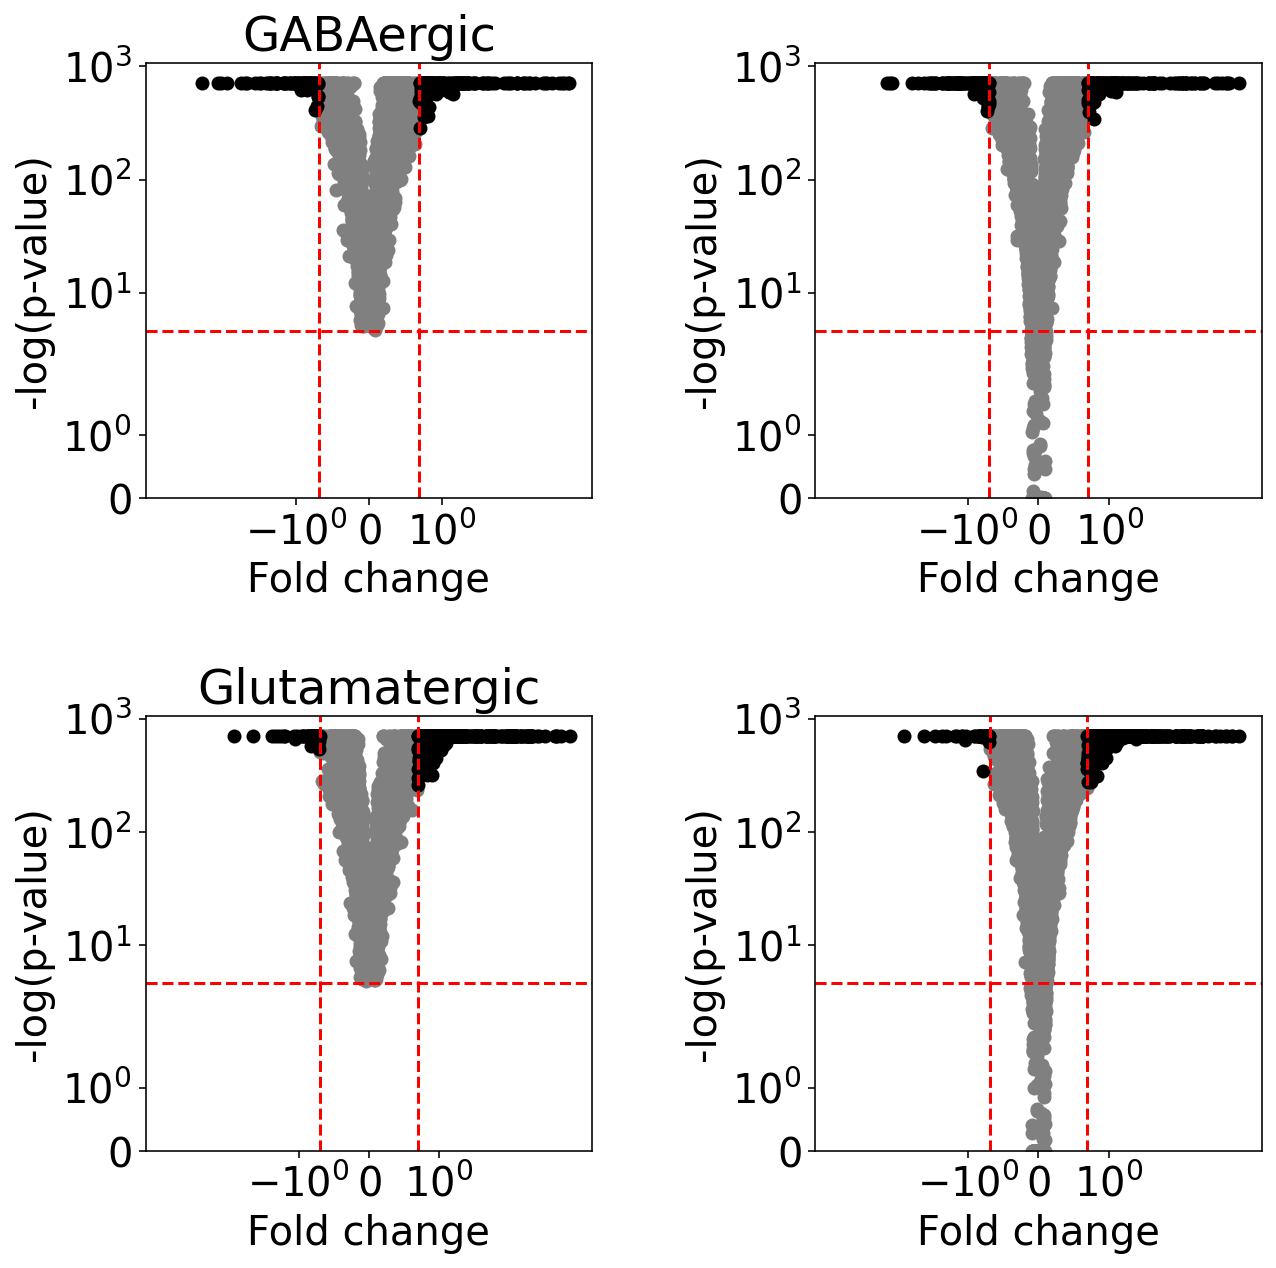

In [24]:
shape = 2
unique = np.unique(isoform.obs.class_label.values)

fig, axs = plt.subplots(figsize=(5*2, 5*shape), ncols=2, nrows=shape)
fig.subplots_adjust(hspace=0.5, wspace=0.5)


for idx, (ax, cluster) in enumerate(zip(axs, unique)):
    data = markers_isoform.query(f"index == '{cluster}'")

    x = data["es"].values.astype(float)
    y = -np.log(data["p_corr"].values.astype(float))

    plot.volcano(x, y, ax[0])
    ax[0].set_title(f"{cluster}")

    data = markers_gene.query(f"index == '{cluster}'")
    x = data["es"].values.astype(float)
    y = -np.log(data["p_corr"].values.astype(float))

    plot.volcano(x, y, ax[1])

fig.show()